In [ ]:
# gen wf
# fit wf

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16}) 

In [20]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [2]:
import numpy as np

## fft stuff

In [62]:
from scipy.fftpack import fft, ifft, fftfreq, rfft, rfftfreq, fftshift, ifftshift 

In [63]:
def planck_taper(times, t1, t2):
    """times: array of times
    t1. for t<=t1 then return 0
    t2. for t>=t2 then return 1
    else return 1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1)"""
    tout = []
    for t in times:
        if t<=t1:
            tout.append(0.)
        elif t>=t2:
            tout.append(1.)
        else:
            tout.append(1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1))
    return np.array(tout)

In [64]:
def conditioned_complex_fft(t, y, t12=None, t34=None, pad_fac=10):
    """
    computes the fft of complex data y
    t {array}, times in units of seconds
    t12, t34 {2-tuple of floats: None}
        t1,t2 = (t12): start and end times of beginning planck taper
        t3,t4 = (t34): start and end times of end planck taper
    pad_fac {'int': 10}
        factor to pad by. split evenly left and right
    returns:
        frequencies, ytilde, window
    """
    y = y.copy()
    dt = t[1]-t[0]
    window = np.ones(len(y))
    
    if t12:
        t1, t2 = t12
        start_window = planck_taper(t, t1, t2)
        window *= start_window
    if t34:
        t3, t4 = t34
        end_window = 1. - planck_taper(t, t3, t4)
        window *= end_window
        
    y *= window
    
    pan_len = int(len(t)*(pad_fac/2))
    
    y = np.pad(y, (pan_len, pan_len), 'constant', constant_values=(0, 0))

    ytilde = fft(y) * dt / 2 # factor of 2 because y is complex
    frequencies = fftfreq(len(y), dt)
    
    return frequencies, ytilde, window

In [3]:
# Setup enviroment to autoreload packages
%load_ext autoreload
%autoreload 2
# Turn on inline plotting with matplotlib, and import needed thigs from nrutils
%matplotlib inline
# Let's only import the catalog search function, and the loading function
from nrutils import scsearch,gwylm

(positive)>> Applying custom matplotlib settings.


In [4]:
from nrutils.core.nrsc import *

## Find a simulation(s) using scsearch

In [5]:
help(scsearch)

Help on function scsearch in module nrutils.core.nrsc:

scsearch(catalog=None, q=None, nonspinning=None, spinaligned=None, spinantialigned=None, precessing=None, nonprecessing=None, equalspin=None, unequalspin=None, antialigned=None, setname=None, notsetname=None, institute=None, keyword=None, notkeyword=None, unique=None, plot=None, exists=None, validate_remnant=None, apply_remnant_fit=None, verbose=None)
    # Function for searching through catalog files.



In [6]:
# Search for simulations
A = scsearch(q=[3.9,8.1], institute='bam', verbose=True)

(scsearch)>> Found institute (=bam) keyword.
(scsearch)>> Found q (=...) keyword.
(scsearch)>> Found verbose (=True) keyword.
## Found 31 possibly degenerate simulations:
[0001][hogshead] NR_data: 1chi0.80-p-q8.00	(q8a08t90dP0_T_96_384)
[0002][raid] data: ns-q8.00	(q8a0a0c05_T_80_420)
[0003][raid] data: ns-q8.00	(q8a0a0c035_T_80_420)
[0004][raid] data: ns-q8.00	(q8a0a0_T_96_504n512)
[0005][raid] data: ns-q8.00	(q8a0a0_T_112_588n768)
[0006][raid] data: ns-q4.00	(q4a0_T_112_448)
[0007][hogshead] NR_data: 1chi0.80-p-q8.00	(q8a08t60Ditm45dr075_96_360)
[0008][hogshead] NR_data: 1chi0.80-p-q8.00	(q8a08t30dPm9.35_r0.5_T_96_360)
[0009][hogshead] NR_data: 1chi0.80-p-q8.00	(q8a08t150dP2_T_96_360)
[0010][hogshead] NR_data: 1chi0.40-p-q8.00	(q8a04t90dP0_T_96_360)
[0011][hogshead] NR_data: 1chi0.40-p-q8.00	(q8a04t90_T_96_360)
[0012][hogshead] NR_data: 1chi0.40-p-q8.00	(q8a04t60_T_96_360)
[0013][hogshead] NR_data: 1chi0.40-p-q8.00	(q8a04t60D_dPm1)
[0014][hogshead] NR_data: 1chi0.40-p-q8.00	(q8a04t30

In [7]:
def get_peak_time(t, amp):
    peak_index = np.argmax(amp)
    peak_time = t[peak_index]
    return peak_time

In [8]:
def resample(x, y, newx):
    return IUS(x, y)(newx)

In [25]:
def compute_sym_waveform(h2m2, h22):
    hplus = (h22 + np.conj(h2m2))/2
    hminus = (h22 - np.conj(h2m2))/2
    return hplus, hminus

In [48]:
def compute_amp(complex_data):
    return np.abs(complex_data)
def compute_phase(complex_data):
    return np.unwrap(np.angle(complex_data))
def compute_dphase(complex_data, time):
    phase = compute_phase(complex_data)
    iphase = IUS(time, phase)
    return iphase.derivative()(time)

In [293]:
def get_co_prec_sym_waveform(ylm, kind='psi4', t1=None, t2=None, npts=1000):
    
    print("ylm simname {}".format(ylm.simname))
    
    print("kind: {}".format(kind))
    
    print("calc initial j frame")
    ylm_coprec = ylm.__calc_initial_j_frame__()
    
    print("calc coprecessing frame")
    ylm_coprec = ylm_coprec.__calc_coprecessing_frame__()
    
    t0_coprec = get_peak_time(ylm_coprec.radiation_axis_info.gwylmo[2,2][kind].t, ylm_coprec.radiation_axis_info.gwylmo[2,2][kind].amp)
    
    t_coprec_shift = ylm_coprec.radiation_axis_info.gwylmo[2,2][kind].t - t0_coprec
    
    if t1 is None:
        t1 = t_coprec_shift[0]
    if t2 is None:
        t2 = t_coprec_shift[-1]
    
    print("t1 = {}".format(t1))
    print("t2 = {}".format(t2))
    
    
    print("computing symmetrised waveform")
    print("**should check sign convention here I use +1.j")
    h2m2_tmp = ylm_coprec[2,-2][kind].wfarr[:,1] + 1.j * ylm_coprec[2,-2][kind].wfarr[:,2]
    h22_tmp = ylm_coprec[2,2][kind].wfarr[:,1] + 1.j * ylm_coprec[2,2][kind].wfarr[:,2]
    
    h22_plus, h22_minus = compute_sym_waveform(h2m2_tmp, h22_tmp)
    print("working with h22_plus")
    
    amp = compute_amp(h22_plus)
    phase = compute_phase(h22_plus)
    dphase = compute_dphase(h22_plus, t_coprec_shift)
    
    newt = np.linspace(t1, t2, npts)

    print("resampling")
    coprec_sym_data = {}
    coprec_sym_data.update({
        't':newt,
        'amp':resample(t_coprec_shift, amp, newt),
        'phi':resample(t_coprec_shift, phase, newt),
        'dphi':resample(t_coprec_shift, dphase, newt),
        'simname':ylm_coprec.simname
    })
    print("**should check sign convention here I use +1.j")
    coprec_sym_data.update({"h22":coprec_sym_data["amp"]*np.exp(1.j*coprec_sym_data["phi"])})
    
    print("done")
    return coprec_sym_data

def compute_fft_coprec_sym(coprec_sym_data, t12=None, t34=None, plot=True):
    t = coprec_sym_data["t"]
    y = coprec_sym_data["h22"]
    amp_td = coprec_sym_data["amp"]
    
    ff, ytilde, win = conditioned_complex_fft(t, y, t12=t12, t34=t34, pad_fac=10)

    if plot:
        plt.figure()
        plt.plot(t, amp_td)
        plt.plot(t, amp_td*win)
        plt.yscale('log')
        plt.ylim(1e-20)
        plt.show()
        plt.close()

    return ff, ytilde

In [50]:
A[24].simname

'q4a04t90_T_96_360'

In [16]:
obj = A[24]
ylm_dict = {
    obj.simname:gwylm( scentry_obj = obj, lmax=2, verbose=False )
}


# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(load_dynamics)>> Trying to load source dynamics ...
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

(load_dynamics)>> Calculating dynamics times by adjusting input waveform_times by extraction radius
(load_dynamics)>> Retrieving method from handler for loading source dyanmics as this is specific to BAM, GT-MAYA, SXS, etc ...
(load_dynamics)>> Loading/Learning dynamics ...
(straighten_wfarr!)>> Non-finite values found in waveform array. Corresponding rows will be removed.
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.
(straighten_wfarr!)>> The waveform time series is now monotonic.
(straighten_wfarr!)>> Repeated time values were found in the array. Offending rows will be removed.
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.
(straighten_wfarr!)>> The wa

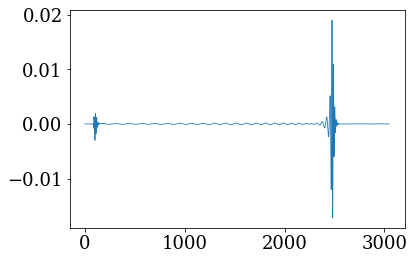

In [34]:
# ylm_dict['q4a04t90_T_96_360'][2,2]['psi4'].wfarr
plt.figure()
plt.plot(ylm_dict['q4a04t90_T_96_360'][2,2]['psi4'].wfarr[:,0], ylm_dict['q4a04t90_T_96_360'][2,2]['psi4'].wfarr[:,1])

In [32]:
ylm_dict['q4a04t90_T_96_360'][2,2]['psi4'].t

array([0.00000e+00, 1.50000e-01, 3.00000e-01, ..., 3.04770e+03,
       3.04785e+03, 3.04800e+03])

In [37]:
dir(ylm_dict['q4a04t90_T_96_360'][2,2]['psi4'])

['__doc__',
 '__flip_cross_sign_convention__',
 '__get_antiderivative__',
 '__get_derivative__',
 '__init__',
 '__lowpassfiltered__',
 '__module__',
 '__rawgwfarr__',
 '__rotate_frame_at_all_times__',
 '__validatet__',
 '__validatewfarr__',
 'align',
 'amp',
 'apply_mask',
 'apply_window',
 'clone',
 'conj',
 'copy',
 'cross',
 'df',
 'dphi',
 'dt',
 'extraction_parameter',
 'f',
 'fd_amp',
 'fd_cross',
 'fd_dphi',
 'fd_k_amp_max',
 'fd_phi',
 'fd_plus',
 'fd_wfarr',
 'fd_y',
 'fdfilter',
 'fs',
 'interpolate',
 'intrp_t_amp_max',
 'k_amp_max',
 'kind',
 'l',
 'label',
 'm',
 'm1',
 'm2',
 'meet',
 'mf',
 'n',
 'pad',
 'phi',
 'plot',
 'plotfd',
 'plottd',
 'plus',
 'postringdown',
 'preinspiral',
 'ref_scentry',
 'reset',
 'setfields',
 'shift_phase',
 't',
 'tshift',
 'verbose',
 'w',
 'wfarr',
 'window',
 'wstart',
 'xf',
 'y']

In [57]:
coprec_sym_dict={}

In [292]:
simname='q4a04t90_T_96_360'
kind='strain'
# kind='psi4'
coprec_sym_dict[simname] = get_co_prec_sym_waveform(ylm_dict[simname], kind=kind)

ylm simname q4a04t90_T_96_360
calc initial j frame
(__rotate_frame_at_all_times__)>> Attempting to rotate dynamics timeseries in this.dynamics
(__rotate_frame_at_all_times__)>> Note that metadata at the scentry level (i.e. this.__scentry__) have not been rotated, but this.Sf, this.R1 and others have been rotated. This includes radiated and remnant quantities.
calc coprecessing frame
(calc_coprecessing_angles)>> The domain values seem unevenly split between positive and negative values. Thus, we will interpret the input as corresponding to TIME DOMAIN data.
(calc_coprecessing_angles)>> The domain values seem evenly split between positive and negative values. Thus, we will interpret the input as corresponding to FREQUENCY DOMAIN data.
(__rotate_frame_at_all_times__)>> Attempting to rotate dynamics timeseries in this.dynamics
(__rotate_frame_at_all_times__)>> Note that metadata at the scentry level (i.e. this.__scentry__) have not been rotated, but this.Sf, this.R1 and others have been ro

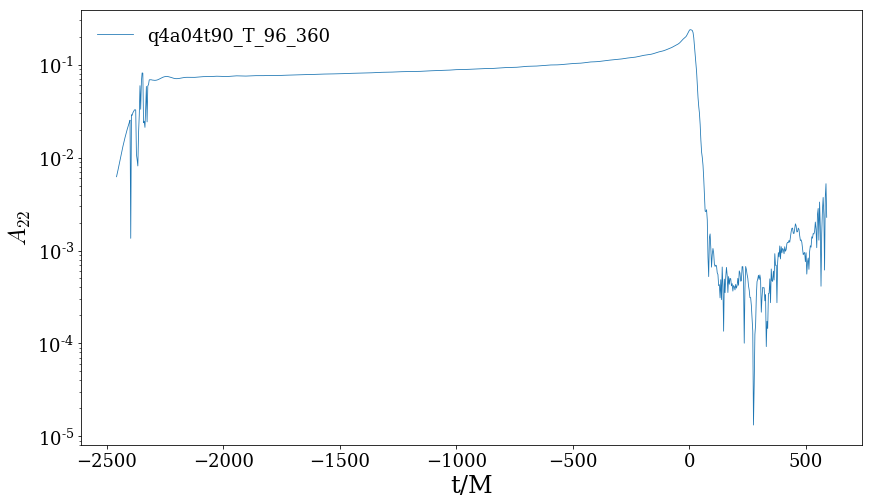

In [294]:
plt.figure(figsize=(14, 8))
plt.plot(coprec_sym_dict['q4a04t90_T_96_360']['t'], coprec_sym_dict['q4a04t90_T_96_360']['amp'], label=coprec_sym_dict['q4a04t90_T_96_360']['simname'])
plt.legend()
# plt.ylim(0,0.6)
# plt.xlim(-2000, 120)
plt.xlabel('t/M')
plt.ylabel(r'$A_{22}$')
plt.yscale('log')

Text(0.5,0,'t/M')

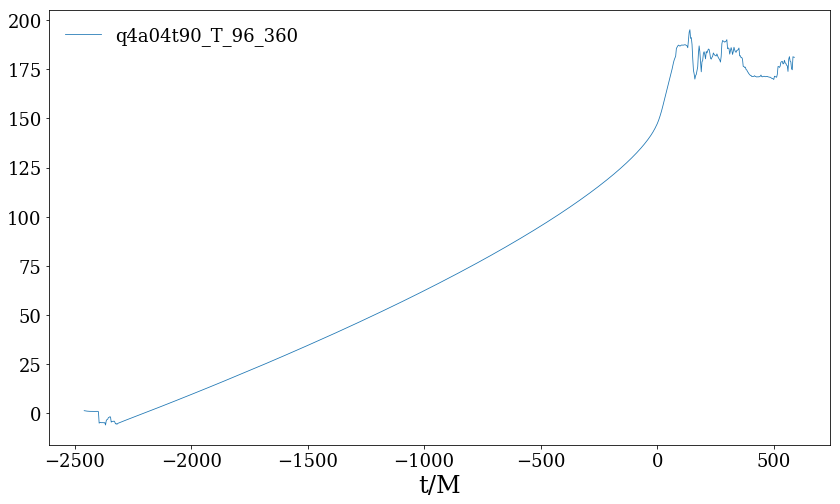

In [295]:
plt.figure(figsize=(14, 8))
plt.plot(coprec_sym_dict['q4a04t90_T_96_360']['t'], coprec_sym_dict['q4a04t90_T_96_360']['phi'], label=coprec_sym_dict['q4a04t90_T_96_360']['simname'])
plt.legend()
# plt.ylim(0,0.6)
# plt.xlim(-2000, 120)
plt.xlabel('t/M')

Text(0.5,0,'t/M')

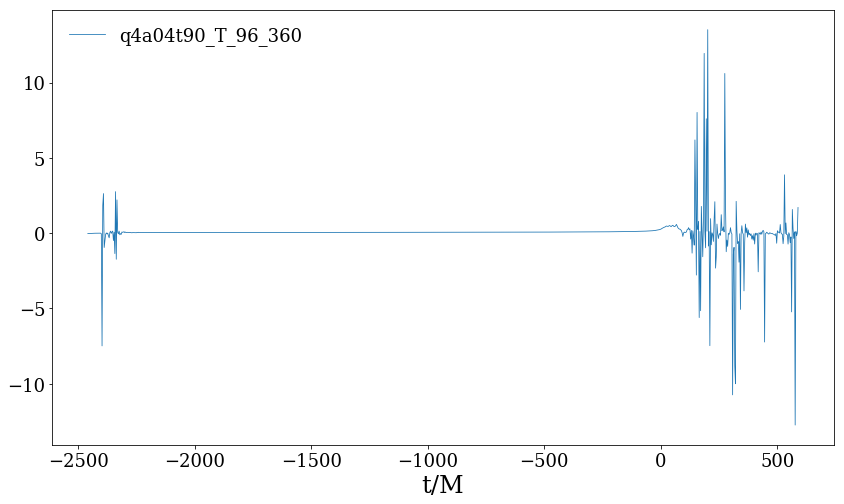

In [296]:
plt.figure(figsize=(14, 8))
plt.plot(coprec_sym_dict['q4a04t90_T_96_360']['t'], coprec_sym_dict['q4a04t90_T_96_360']['dphi'], label=coprec_sym_dict['q4a04t90_T_96_360']['simname'])
plt.legend()
# plt.ylim(0,0.6)
# plt.xlim(-2000, 120)
plt.xlabel('t/M')

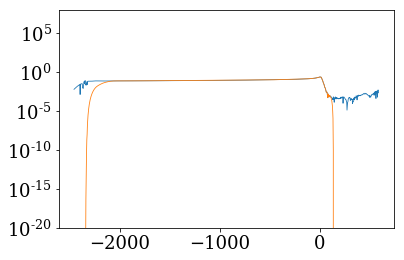

In [297]:
ff, ytilde = \
    compute_fft_coprec_sym(coprec_sym_dict['q4a04t90_T_96_360'], t12=[-2350, -2000], t34=[100, 140])

In [298]:
def fft_post_process(f, ytilde, take_pos_f=True, f_min=0.01, f_max=0.12):
    if take_pos_f:
#         mask = f > 0
        mask = (f > f_min) & (f < f_max)
        f = f[mask]
        ytilde = ytilde[mask]
    else:
#         mask = f < 0
        mask = (f < -f_min) & (f > -f_max)
        f = f[mask]
        ytilde = ytilde[mask]
        
    amp = compute_amp(ytilde)
    phase = compute_phase(ytilde)
    dphase = compute_dphase(ytilde, f)
        
    return f, ytilde, amp, phase, dphase

In [329]:
ff_post, ytilde_post, amp_post, phase_post, dphase_post = fft_post_process(ff, ytilde, take_pos_f=True, f_min=0.01, f_max=0.12)

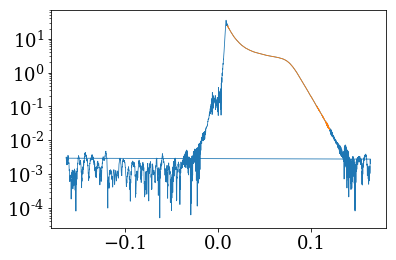

In [330]:
plt.figure()
plt.plot(ff, np.abs(ytilde))
plt.plot(ff_post, np.abs(ytilde_post))
plt.yscale('log')

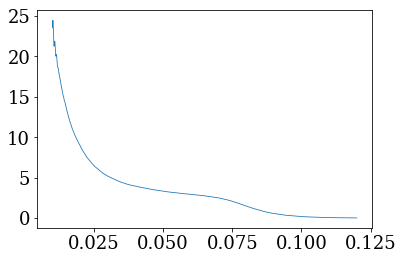

In [331]:
plt.figure()
plt.plot(ff_post, amp_post)

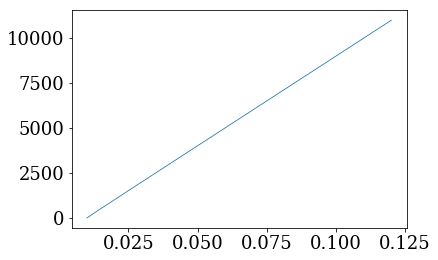

In [332]:
plt.figure()
plt.plot(ff_post, phase_post)

(-6787.523058949315, -5987.523058949315)

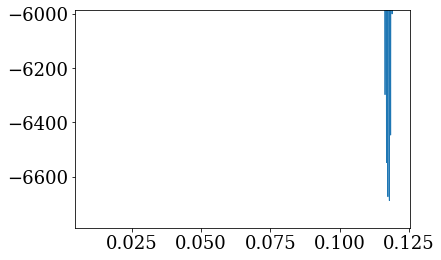

In [512]:
dphase_shifted = dphase_post-dphase_post[0]
dphase_min = np.min(dphase_shifted)

plt.figure()
plt.plot(ff_post, dphase_shifted)
plt.ylim(dphase_min-100, dphase_min+400)

In [352]:
# get data to fit
# f1, f2 = 0.05, 0.1
f1, f2 = 0.03, 0.1
mask = (ff_post>f1) & (ff_post<f2)
x = ff_post[mask]
y = dphase_shifted[mask]

proxy_frd = x[np.argmin(y)]
print("proxy_frd = {}".format(proxy_frd))

proxy_frd = 0.0997271832498


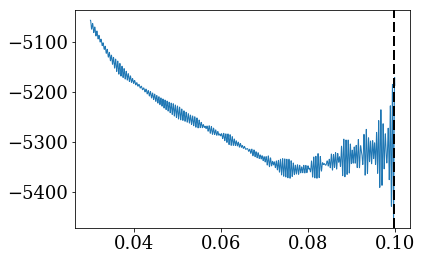

In [353]:
plt.figure()
plt.plot(x, y, lw=1)
plt.axvline(proxy_frd, c='k', ls='--', lw=2)

In [354]:
import phenom

In [355]:
def get_remnant(eta, chi1z, chi2z):
    fin_spin = phenom.remnant.FinalSpin0815(eta, chi1z, chi2z)
    fring = phenom.remnant.fring(eta, chi1z, chi2z, fin_spin)
    fdamp = phenom.remnant.fdamp(eta, chi1z, chi2z, fin_spin)
    final_mass = 1.0 - phenom.EradRational0815(eta, chi1z, chi2z)
    
    return final_mass, fin_spin, fring, fdamp

In [356]:
q4a04t30_remnant = {}
final_mass_tmp, fin_spin_tmp, fring_tmp, fdamp_tmp = get_remnant(phenom.eta_from_q(4), 0, 0)
q4a04t30_remnant.update({
    "final_mass":final_mass_tmp, "fin_spin":fin_spin_tmp, "fring":fring_tmp, "fdamp":fdamp_tmp
})


In [357]:
from scipy.optimize import curve_fit

In [462]:
def dphimrd_func(f, a1, a2, a3, a4, a5, fdamp, frd):
    part1 = a1 + a2*f**(-2) + a3*f**(-1/4.)
#     part2 = a4 * fdamp / (fdamp**2 + (f-frd*(1-a5))**2)
    part2 = a4 * fdamp / (fdamp**2 + (f-a5*frd)**2)
    return part1 + part2

In [502]:
epsilon = 1e-4

# mod_frd_guess = proxy_frd
mod_frd_guess = q4a04t30_remnant['fring']

frd = q4a04t30_remnant['fring']

fdamp_guess = q4a04t30_remnant['fdamp']

p0 = [1,1,1,1,1,0.01,frd_guess]
bounds = [
    (-10000,100),
    (-100,100),
    (-1000,1000),
    (-1000,100),
    (-5,5),
    (fdamp_guess-0.1,fdamp_guess+0.1),
    (frd-epsilon, frd+epsilon),
]
bounds = np.array(bounds)
bounds = bounds.T

In [503]:
popt, pcov = curve_fit(dphimrd_func, x, y, p0=p0, bounds=bounds)

In [504]:
popt

array([-5.28318555e+03,  2.37923363e-01, -1.47360964e+01, -1.30226975e+00,
        1.02994636e+00,  1.55064524e-02,  7.43149233e-02])

In [505]:
popt[-1]

0.07431492333153424

In [506]:
q4a04t30_remnant['fring']

0.0743304543028134

In [507]:
q4a04t30_remnant['fring'] * popt[-3]

0.07655638055679438

In [508]:
fdamp_guess

0.014003747737603085

In [509]:
popt[-2]

0.015506452371460241

Text(0.5,1,'q4a04t90_T_96_360')

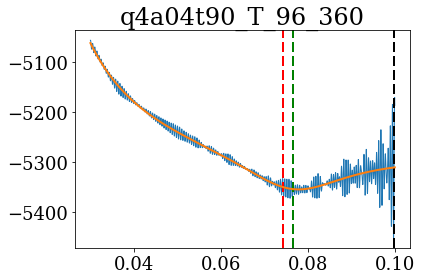

In [510]:
plt.figure()
plt.plot(x, y, lw=1)
plt.axvline(proxy_frd, c='k', ls='--', lw=2)
plt.axvline(q4a04t30_remnant['fring'], c='r', ls='--', lw=2)

plt.axvline(q4a04t30_remnant['fring'] * popt[-3], c='g', ls='--', lw=2)

plt.plot(x, dphimrd_func(x, *popt), lw=2)
plt.title(coprec_sym_dict['q4a04t90_T_96_360']['simname'])

Text(0.5,1,'q4a04t90_T_96_360')

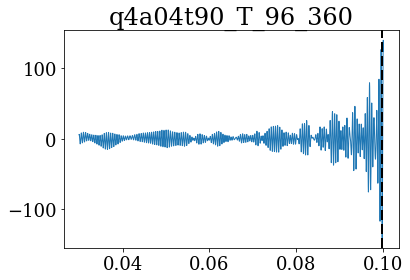

In [511]:
plt.figure()
plt.plot(x, y - dphimrd_func(x, *popt), lw=1)
plt.axvline(proxy_frd, c='k', ls='--', lw=2)
plt.title(coprec_sym_dict['q4a04t90_T_96_360']['simname'])

In [ ]:
# save both strain and psi4 data

In [ ]:
# plot strain and psi4 dphi

In [ ]:
# get phase strain from psi4 by dividing psi4 and not from fixed frequency.